In [44]:
import numpy as np
import matplotlib.pyplot as plt
import utils

plt.rcParams.update({
    'figure.figsize': (12, 4),
    'font.size': 10,
    'lines.linewidth': 1.5
})

from simulator.csad import CSAD_DP_6DOF

dt = 0.02
simtime = 20
t = np.arange(0, simtime, dt)

vessel = CSAD_DP_6DOF(dt)
# vessel._x[3] = np.deg2rad(2)
#vessel._x[4] = np.deg2rad(5)

x = np.zeros((len(t), 12))
x[0] = vessel._x
eta = np.zeros((len(t), 6))
eta[0] = vessel._x[:6]

Jinv = utils.J(eta[0])
print(vessel._G@Jinv@eta[0])

tau_env = np.zeros((len(t), 6))
wave_freq = 2
tau_env[:, 2] = np.sin(wave_freq*t) * 100   # Wave load ich in heave
Uc = 0.0
betac = 0.0

for i in range(1, len(t)):
    vessel.x_dot(Uc, betac, tau_env[i])
    vessel.integrate()
    eta[i] = vessel.get_eta()
    x[i] = vessel._x

# Convert from rad and rad/s to deg and deg/s
x[:, 3:6] = np.rad2deg(x[:, 3:6])
x[:, 9:] = np.rad2deg(x[:, 9:])



[0. 0. 0. 0. 0. 0.]


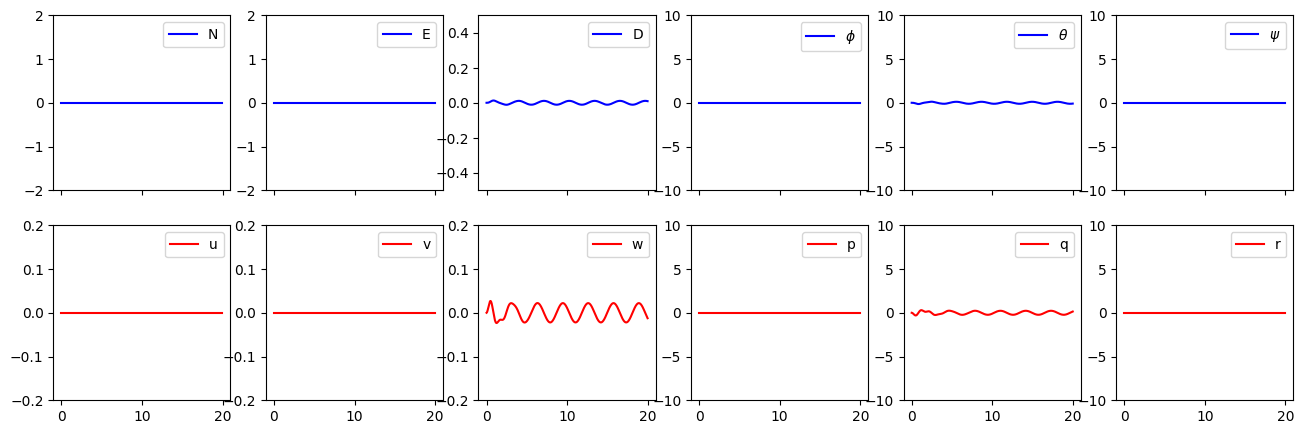

In [45]:
# Plot results
fig, axs = plt.subplots(2, 6, sharex=True, figsize=(16, 5))
labels = ['N', 'E', 'D', r'$\phi$', r"$\theta$", r"$\psi$", "u", "v", "w", 'p', 'q', 'r']
colors = 6*['blue'] + 6*['red']
ylims = [
    (-2, 2),
    (-2, 2),
    (-.5, 0.5),
    (-10, 10),
    (-10, 10),
    (-10, 10),
    (-.2, .2),
    (-.2, .2),
    (-.2, .2),
    (-10, 10),
    (-10, 10),
    (-10, 10),
]
for i in range(12):
    plt.sca(axs[i//6, i - 6*(i//6)])
    plt.plot(t, x[:, i], color=colors[i], label=labels[i])
    plt.ylim(ylims[i])
    plt.legend()

plt.show()

In [30]:
print(np.round(vessel._G, 2))

[[    0.       0.       0.       0.       0.       0.  ]
 [    0.       0.       0.       0.       0.       0.  ]
 [    0.       0.   10463.07     0.     870.67     0.  ]
 [    0.       0.       0.      81.09     0.       0.  ]
 [    0.       0.     870.67     0.    4880.81     0.  ]
 [    0.       0.       0.       0.       0.       0.  ]]


In [4]:
print(np.round(vessel._D, 2))

[[ 3.6060e+01  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  2.8259e+02  0.0000e+00  2.3000e+00  0.0000e+00  3.5800e+00]
 [ 0.0000e+00  0.0000e+00  7.3416e+02  0.0000e+00  8.9830e+01  0.0000e+00]
 [ 0.0000e+00  2.3000e+00  0.0000e+00  3.3300e+00  0.0000e+00 -5.2000e-01]
 [ 0.0000e+00  0.0000e+00  8.9830e+01  0.0000e+00  3.5486e+02  0.0000e+00]
 [ 0.0000e+00  3.5800e+00  0.0000e+00 -5.2000e-01  0.0000e+00  9.9110e+01]]


In [5]:
print(np.round(vessel._Dp, 2))

[[ 1.9630e+01  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  1.5382e+02  0.0000e+00  2.3000e+00  0.0000e+00  3.5800e+00]
 [ 0.0000e+00  0.0000e+00  7.3416e+02  0.0000e+00  8.9830e+01  0.0000e+00]
 [ 0.0000e+00  2.3000e+00  0.0000e+00  1.3000e-01  0.0000e+00 -5.2000e-01]
 [ 0.0000e+00  0.0000e+00  8.9830e+01  0.0000e+00  3.5486e+02  0.0000e+00]
 [ 0.0000e+00  3.5800e+00  0.0000e+00 -5.2000e-01  0.0000e+00  4.8600e+01]]


In [31]:
print(f"Natural Frequencies [rad/s]".center(80, '-'))
wn = np.sqrt(vessel._G/vessel._M)
wn[np.isnan(wn)] = 0
print(np.round(wn, 2))
print(f"Natural Period".center(80, '-'))
tn = 2*np.pi/wn
tn[np.isinf(tn)] = 0
print(np.round(tn, 2))

--------------------------Natural Frequencies [rad/s]---------------------------
[[ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.    0.    0.  ]
 [ 0.    0.    5.59  0.    5.74  0.  ]
 [ 0.   -0.    0.    4.24  0.    0.  ]
 [ 0.    0.    5.74  0.    5.65  0.  ]
 [ 0.    0.    0.   -0.    0.    0.  ]]
---------------------------------Natural Period---------------------------------
[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.12 0.   1.1  0.  ]
 [0.   0.   0.   1.48 0.   0.  ]
 [0.   0.   1.1  0.   1.11 0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


C:\Users\j-ehy\AppData\Local\Temp\ipykernel_27536\3910662644.py:2: RuntimeWarning: invalid value encountered in divide
  wn = np.sqrt(vessel._G/vessel._M)
C:\Users\j-ehy\AppData\Local\Temp\ipykernel_27536\3910662644.py:2: RuntimeWarning: invalid value encountered in sqrt
  wn = np.sqrt(vessel._G/vessel._M)
C:\Users\j-ehy\AppData\Local\Temp\ipykernel_27536\3910662644.py:6: RuntimeWarning: divide by zero encountered in divide
  tn = 2*np.pi/wn
